# Comparisons of Divergent Semantic Integration scores in LLMs generated creative writing tasks
Table of content:
1. Load data and concatenate
2. Overview
3. Plot models' performance across temperatures
### Dependencies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import glob

In [2]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_tvals_pvals(results_df, variable, metric="DSI"):
    variables = results_df[variable].unique()
    n_variables = len(variables)

    # Compute t-tests
    pvals = np.zeros((n_variables, n_variables))
    tvals = np.zeros((n_variables, n_variables))
    for i, model1 in enumerate(variables):
        for j, model2 in enumerate(variables):
            if i >= j:
                continue
            model1_scores = results_df[results_df[variable] == model1][metric].dropna()
            model2_scores = results_df[results_df[variable] == model2][metric].dropna()
            tval, pval = ttest_ind(model1_scores, model2_scores)
            tvals[i, j] = tval
            tvals[j, i] = -tval   # assign negative t-value for reverse comparison
            pvals[i, j] = pval
            pvals[j, i] = pval


    # Correct for multiple comparisons
    reject, pvals_corrected, _, _ = multipletests(
        pvals.flatten(),
        alpha=0.05,
        method="fdr_bh",
        is_sorted=False,
        returnsorted=False,
    )
    pvals_corrected = pvals_corrected.reshape((n_variables, n_variables))

    # Generate dataframes
    tvals_df = pd.DataFrame(tvals, index=variables, columns=variables)
    pvals_df = pd.DataFrame(pvals_corrected, index=variables, columns=variables)

    return tvals_df, pvals_df

def plot_tvals_matrix(tvals_df, pvals_df, save=None, size=(5, 3.5)):
    # Create a mask to only show the lower half of the matrix
    mask = np.triu(np.ones_like(tvals_df, dtype=bool))
    # round t-values to 2 decimals
    tvals_df = tvals_df.round(2)
    # Generate the annotations for each cell indicating significance level
    pval_annotations = pvals_df.applymap(lambda x: "***" if x < 0.001 else "**" if x < 0.01 else "*" if x < 0.05 else "")
    # Combine t-values and significance annotations
    annotations = pval_annotations + "\n" + tvals_df.astype(str)
    # Create a mask to only show the lower half of the matrix (exclude first row and last column)
    plt.figure(figsize=(size))

    mask = np.triu(np.ones_like(tvals_df, dtype=bool))
    #mask = mask[1:, :-1]
    # remove the first row and last column from the mask and the tvals_df
    mask = mask[1:, :-1]
    tvals_df = tvals_df.iloc[1:, :-1].copy()
    pval_annotations = pval_annotations.iloc[1:, :-1].copy()
    # Create the heatmap
    ax = sns.heatmap(tvals_df, annot=pval_annotations, mask=mask, fmt="s", cmap="Reds", cbar_kws={'label': 't-value'})
    for text in ax.texts:
        text.set_size(14)
    # make background transparent
    ax.patch.set_alpha(0)
    # Add the title
    #plt.title("t-values matrix")
    # adjust all font sizes
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)
    # set y label rotation
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    # set x label rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
    # adjust font size of colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    # adjust font size of colorbar label
    cbar.set_label("t-values", fontsize=14)
    # remove x-axis title
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.tight_layout()

    if save is not None:
        plt.savefig(f"{save}.png", dpi=300)
    # Show the plot
    plt.show()


In [3]:
results_df = pd.read_csv("../ALL_DSI-lziv_output.csv", header=0, sep=",")


In [4]:
results_df['temp'].replace('n.a.', 'Mid', inplace=True)

## Plot all distributions seprately to get an overview

Works: synopsis Mid
Works: synopsis Very High
Works: synopsis Very Low
Works: synopsis High
synopsis Mid-High
Works: synopsis Low
synopsis Mid-Low
Works: haiku Mid
Works: haiku Very High
Works: haiku Very Low
Works: haiku High
haiku Mid-High
Works: haiku Low
haiku Mid-Low
Works: flash-fiction Mid
flash-fiction Very High
flash-fiction Very Low
Works: flash-fiction High
Works: flash-fiction Mid-High
Works: flash-fiction Low


c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\seaborn\axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


Works: flash-fiction Mid-Low


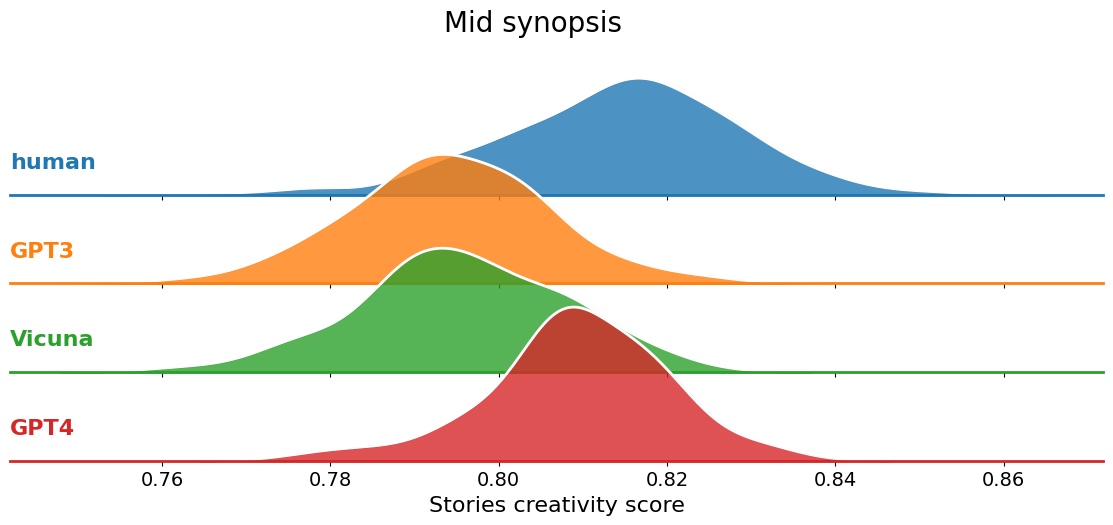

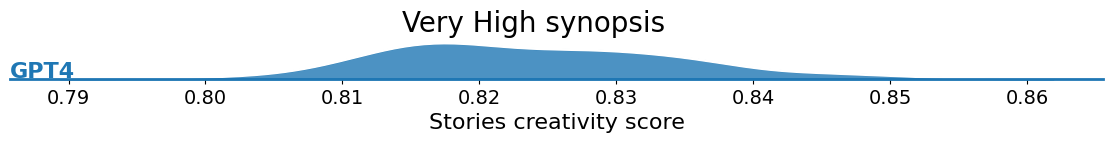

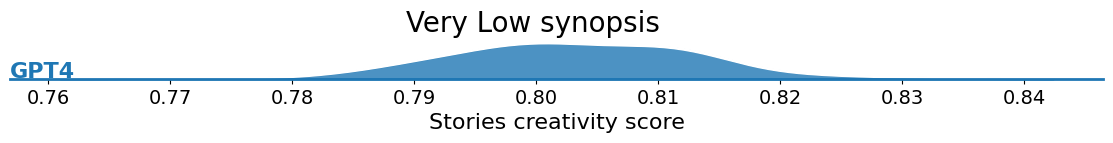

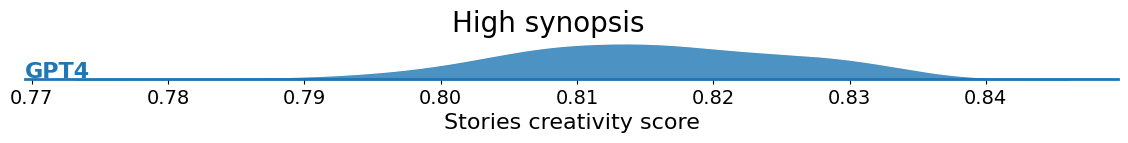

<Figure size 1170x0 with 0 Axes>

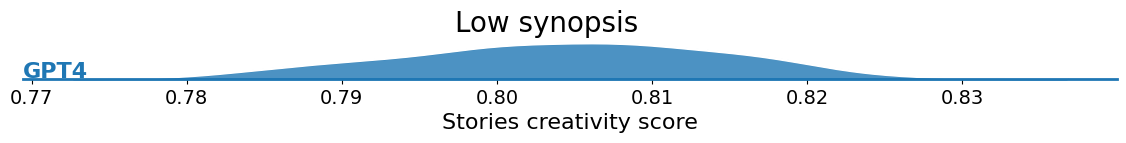

<Figure size 1170x0 with 0 Axes>

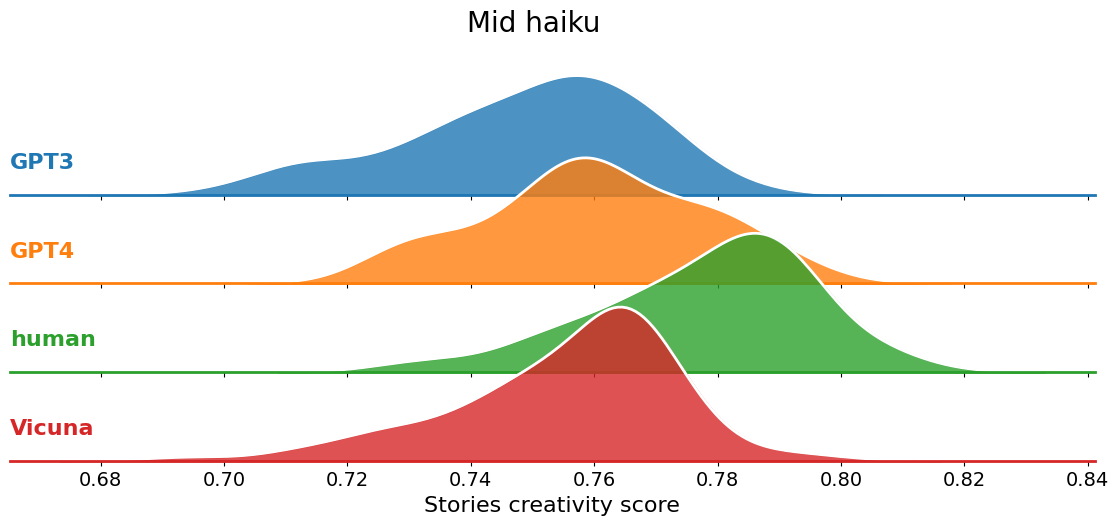

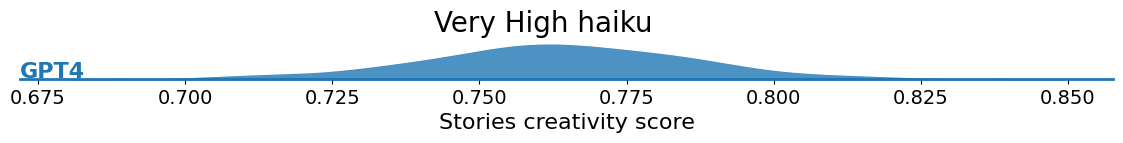

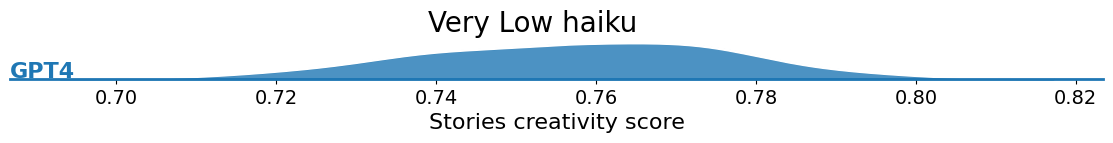

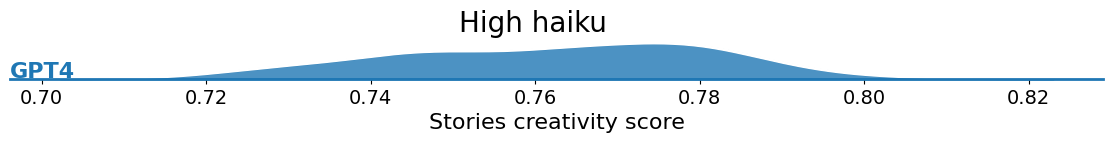

<Figure size 1170x0 with 0 Axes>

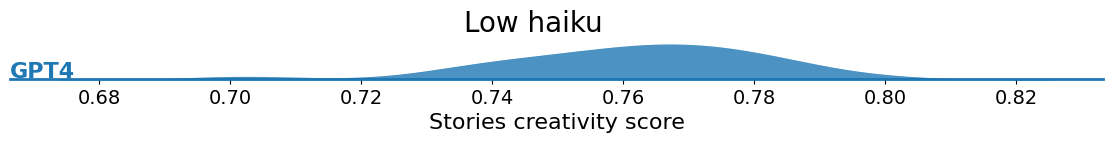

<Figure size 1170x0 with 0 Axes>

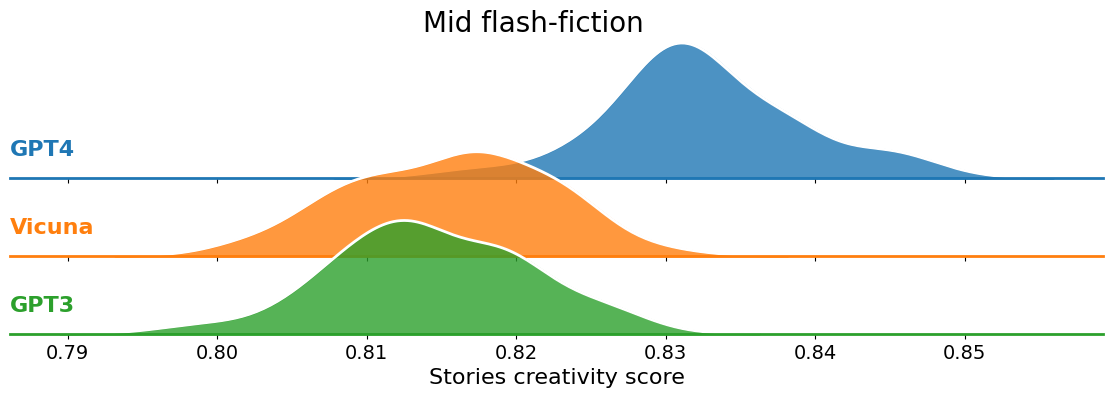

<Figure size 1170x0 with 0 Axes>

<Figure size 1170x0 with 0 Axes>

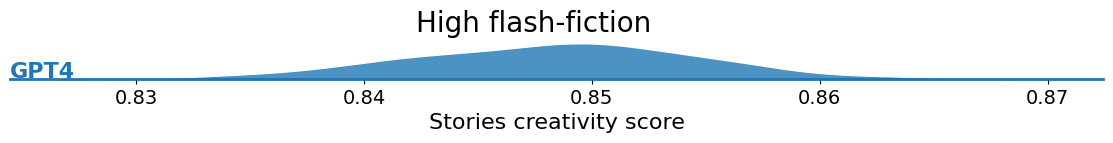

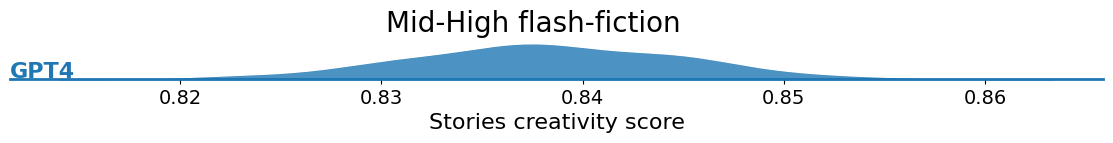

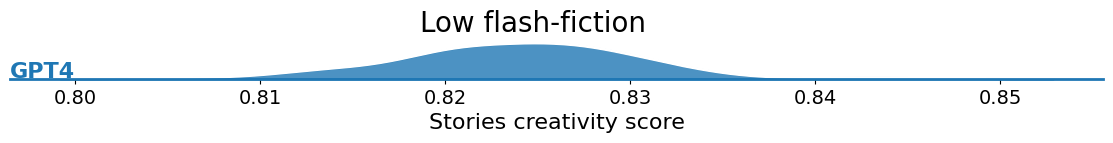

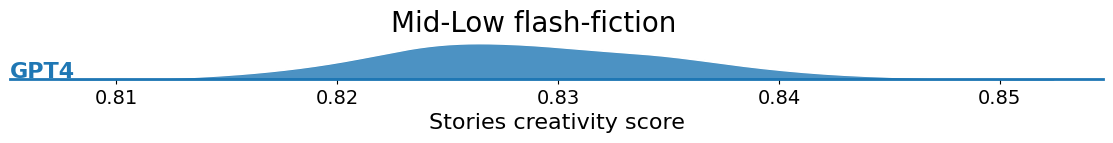

In [5]:
for condition in results_df['condition'].unique():
    for temp in results_df['temp'].unique(): 
        df = results_df[['model', 'condition', 'DSI']].loc[(results_df['condition']==condition) & (results_df['temp']==temp)]
        try:
            g = sns.FacetGrid(df, row="model", hue="model", aspect=9, height=1.3,)
            print("Works:", condition, temp)
        except ValueError:
            print(condition, temp)
            continue

        # make transparent background
        for ax in g.axes.flat:
            ax.set_facecolor('none')
        # Draw the densities in a few steps
        g.map(sns.kdeplot, "DSI",
            bw_adjust=1, clip_on=False,
            fill=True, alpha=0.8, linewidth=1.5)
        g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
        # passing color=None to refline() uses the hue mapping
        g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            # check if Human is in the label
            ax.text(0, .2, label, fontweight="bold", color=color,
                    ha="left", va="center", transform=ax.transAxes,fontsize=16)
        g.map(label, "DSI")


        for ax in g.axes.flat:
            ax.set_xlabel('Stories creativity score', fontsize=16)
            for label in ax.get_xticklabels():
                    label.set_fontsize(14)
        # Remove axes details that don't play well with overlap
        g.set_titles("")
        # Set the subplots to overlap
        g.figure.subplots_adjust(hspace=-.45)
        g.set(yticks=[], ylabel="")
        g.despine(bottom=True, left=True)
        g.fig.suptitle(f'{temp} {condition}', fontsize=20)
        #g.savefig(f'../figures/DSI_ridge_{temp}_{condition}.png', dpi=300, bbox_inches='tight')

## Synopsis Mid Temp Models comparison

Text(0.5, 0.98, 'Divergent Semantic Integration of Synopses')

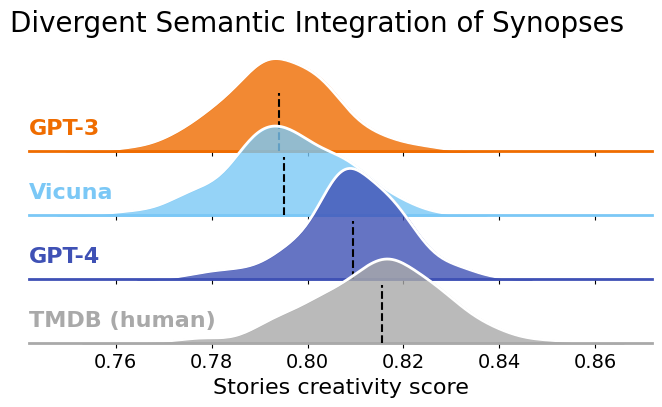

In [6]:
colors = {'GPT-3':'#EF6C00',
          'GPT-4':'#3F51B5',
          'TMDB (human)':'darkgrey',
          'Vicuna':'#7BC8F6'}

df = results_df[['model', 'condition', 'DSI']].loc[(results_df['condition']=='synopsis') & (results_df['temp']=='Mid')]
# rename model GPT3 to GPT-3
df["model"].replace("GPT3", "GPT-3", inplace=True)
# rename model GPT4 to GPT-4
df["model"].replace("GPT4", "GPT-4", inplace=True)

df['model'].replace('human', 'TMDB (human)', inplace=True)
# Calculate the medians
medians = df.groupby("model")["DSI"].median()
# Order models by median
order = medians.sort_values().index

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)

g = sns.FacetGrid(df, row="model", hue="model", aspect=9, height=1.3, palette=colors)
# set figure size
g.fig.set_size_inches(7, 4)

# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "DSI",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
    median = medians[label]
    ax.axvline(median, color='black', linestyle='--', ymin=0, ymax=0.5)
    ax.grid(False)

g.map(label, "DSI")

for ax in g.axes.flat:
    ax.set_xlabel('Stories creativity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.fig.suptitle('Divergent Semantic Integration of Synopses', fontsize=20)
#g.savefig(f'../figures/DSI_synopsis_mid_temp.png', dpi=300, bbox_inches='tight')


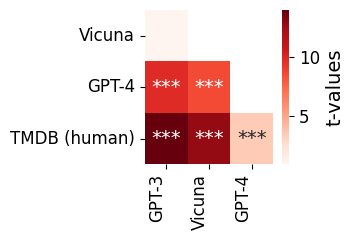

In [7]:
# Calculate the medians
df = results_df[['model', 'condition', 'DSI']].loc[(results_df['condition']=='synopsis') & (results_df['temp']=='Mid')]
# rename model GPT3 to GPT-3
df["model"].replace("GPT3", "GPT-3", inplace=True)
# rename model GPT4 to GPT-4
df["model"].replace("GPT4", "GPT-4", inplace=True)

df['model'].replace('human', 'TMDB (human)', inplace=True)
medians = df.groupby("model")["DSI"].median()
# Order models by median
order = medians.sort_values().index

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)

# Recompute the t-values and p-values
tvals_df, pvals_df = compute_tvals_pvals(df, 'model')

# Make sure the dataframes are ordered correctly
tvals_df = tvals_df.loc[order, order]
pvals_df = pvals_df.loc[order, order]


#use plot tval function
plot_tvals_matrix(
    tvals_df,
    pvals_df,
    save='../figures/tvals_synopsis_mid_temp.png',
    size=(3.5, 2.5))

## Lempel-Ziv for synopses

Text(0.5, 0.98, 'Divergent Semantic Integration of Synopses')

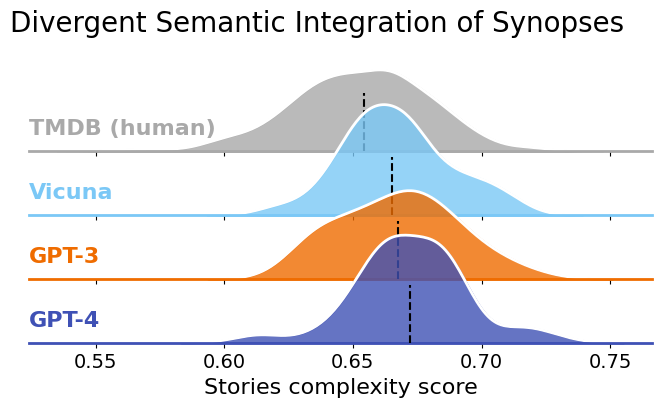

In [8]:
colors = {'GPT-3':'#EF6C00',
          'GPT-4':'#3F51B5',
          'TMDB (human)':'darkgrey',
          'Vicuna':'#7BC8F6'}

df = results_df[['model', 'condition', 'lziv']].loc[(results_df['condition']=='synopsis') & (results_df['temp']=='Mid')]
# rename model GPT3 to GPT-3
df["model"].replace("GPT3", "GPT-3", inplace=True)
# rename model GPT4 to GPT-4
df["model"].replace("GPT4", "GPT-4", inplace=True)

df['model'].replace('human', 'TMDB (human)', inplace=True)
# Calculate the medians
medians = df.groupby("model")["lziv"].median()
# Order models by median
order = medians.sort_values().index

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)

g = sns.FacetGrid(df, row="model", hue="model", aspect=9, height=1.3, palette=colors)
# set figure size
g.fig.set_size_inches(7, 4)

# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "lziv",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "lziv", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
    median = medians[label]
    ax.axvline(median, color='black', linestyle='--', ymin=0, ymax=0.5)
    ax.grid(False)

g.map(label, "lziv")

for ax in g.axes.flat:
    ax.set_xlabel('Stories complexity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.fig.suptitle('Divergent Semantic Integration of Synopses', fontsize=20)
#g.savefig(f'../figures/LZ_synopsis_mid_temp.png', dpi=300, bbox_inches='tight')


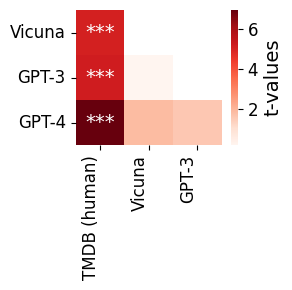

In [9]:
# Calculate the medians
df = results_df[['model', 'condition', 'lziv']].loc[(results_df['condition']=='synopsis') & (results_df['temp']=='Mid')]
# rename model GPT3 to GPT-3
df["model"].replace("GPT3", "GPT-3", inplace=True)
# rename model GPT4 to GPT-4
df["model"].replace("GPT4", "GPT-4", inplace=True)

df['model'].replace('human', 'TMDB (human)', inplace=True)
medians = df.groupby("model")["lziv"].median()
# Order models by median
order = medians.sort_values().index

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)

# Recompute the t-values and p-values
tvals_df, pvals_df = compute_tvals_pvals(df, 'model', metric="lziv")

# Make sure the dataframes are ordered correctly
tvals_df = tvals_df.loc[order, order]
pvals_df = pvals_df.loc[order, order]


#use plot tval function
plot_tvals_matrix(
    tvals_df,
    pvals_df,
    save='../figures/tvals_synopsis_mid_temp_lziv.png',
    size=(3, 3))

## Haiku model comparison

Text(0.5, 0.98, 'Divergent Semantic Integration of Haikus')

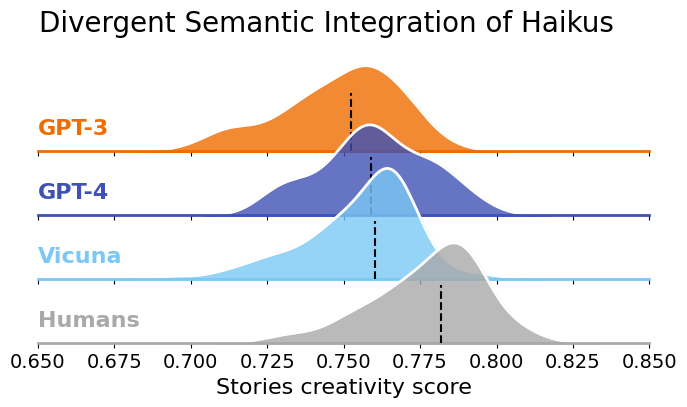

In [10]:

colors = {'GPT-3':'#EF6C00',
          'GPT-4':'#3F51B5',
          'Humans':'darkgrey',
          'Vicuna':'#7BC8F6'}

df = results_df[['model', 'condition', 'DSI']].loc[(results_df['condition']=='haiku') & (results_df['temp']=='Mid')]
# rename model GPT3 to GPT-3
df["model"].replace("GPT3", "GPT-3", inplace=True)
# rename model GPT4 to GPT-4
df["model"].replace("GPT4", "GPT-4", inplace=True)
df["model"].replace("human", "Humans", inplace=True)

# Calculate the medians
medians = df.groupby("model")["DSI"].median()
# Order models by median
order = medians.sort_values().index

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)

g = sns.FacetGrid(df, row="model", hue="model", aspect=9, height=1.3, palette=colors)
# set figure size
g.fig.set_size_inches(7, 4)

# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "DSI",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
    median = medians[label]
    ax.axvline(median, color='black', linestyle='--', ymin=0, ymax=0.5)
    ax.grid(False)

g.map(label, "DSI")

for ax in g.axes.flat:
    ax.set_xlabel('Stories creativity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# set x axis range
g.set(xlim=(0.65, 0.85))
g.fig.suptitle('Divergent Semantic Integration of Haikus', fontsize=20)
#g.savefig(f'../figures/DSI_haiku_mid_temp.png', dpi=300, bbox_inches='tight')


model
GPT-3     0.748706
Vicuna    0.755532
GPT-4     0.760067
human     0.777887
Name: DSI, dtype: float64


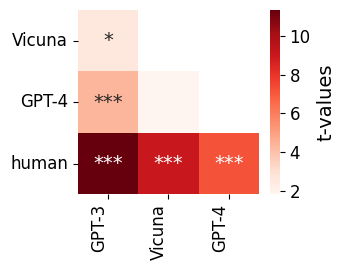

In [11]:
# Calculate the medians
df = results_df[['model', 'condition', 'DSI']].loc[(results_df['condition']=='haiku') & (results_df['temp']=='Mid')]
# rename model GPT3 to GPT-3
df["model"].replace("GPT3", "GPT-3", inplace=True)
# rename model GPT4 to GPT-4
df["model"].replace("GPT4", "GPT-4", inplace=True)

means = df.groupby("model")["DSI"].mean()
# Order models by median
order = means.sort_values().index

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)

#print mean of each model
print(df.groupby("model")["DSI"].mean())
# Recompute the t-values and p-values
tvals_df, pvals_df = compute_tvals_pvals(df, "model")

# Make sure the dataframes are ordered correctly
tvals_df = tvals_df.loc[order, order]
pvals_df = pvals_df.loc[order, order]


#use plot tval function
plot_tvals_matrix(
    tvals_df,
    pvals_df,
    save="../figures/tvals_matrix_haiku",
    size=(3.5, 2.8))

## Haiku LZ

Text(0.5, 0.98, 'Divergent Semantic Integration of Haikus')

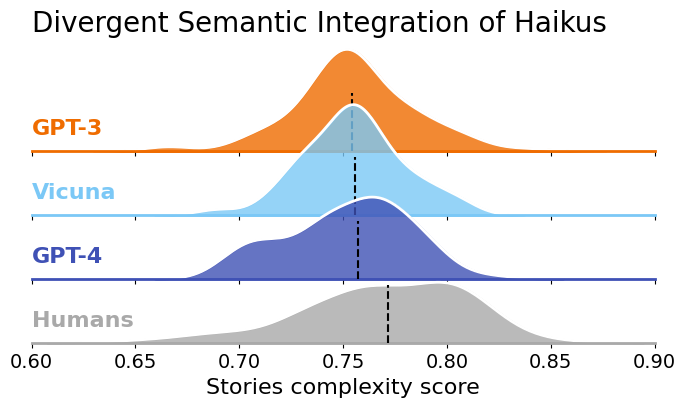

In [12]:

colors = {'GPT-3':'#EF6C00',
          'GPT-4':'#3F51B5',
          'Humans':'darkgrey',
          'Vicuna':'#7BC8F6'}

df = results_df[['model', 'condition', 'lziv']].loc[(results_df['condition']=='haiku') & (results_df['temp']=='Mid')]
# rename model GPT3 to GPT-3
df["model"].replace("GPT3", "GPT-3", inplace=True)
# rename model GPT4 to GPT-4
df["model"].replace("GPT4", "GPT-4", inplace=True)
df["model"].replace("human", "Humans", inplace=True)

# Calculate the medians
medians = df.groupby("model")["lziv"].median()
# Order models by median
order = medians.sort_values().index

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)

g = sns.FacetGrid(df, row="model", hue="model", aspect=9, height=1.3, palette=colors)
# set figure size
g.fig.set_size_inches(7, 4)

# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "lziv",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "lziv", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
    median = medians[label]
    ax.axvline(median, color='black', linestyle='--', ymin=0, ymax=0.5)
    ax.grid(False)

g.map(label, "lziv")

for ax in g.axes.flat:
    ax.set_xlabel('Stories complexity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# set x axis range
g.set(xlim=(0.60, 0.90))
g.fig.suptitle('Divergent Semantic Integration of Haikus', fontsize=20)
#g.savefig(f'../figures/lziv_haiku_mid_temp.png', dpi=300, bbox_inches='tight')


model
GPT-4     0.751778
Vicuna    0.754825
GPT-3     0.754979
human     0.770130
Name: lziv, dtype: float64


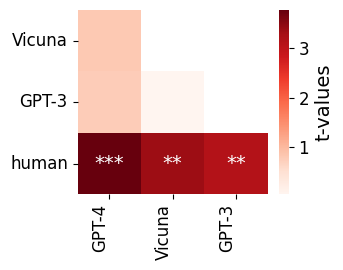

In [13]:
# Calculate the medians
df = results_df[['model', 'condition', 'lziv']].loc[(results_df['condition']=='haiku') & (results_df['temp']=='Mid')]
# rename model GPT3 to GPT-3
df["model"].replace("GPT3", "GPT-3", inplace=True)
# rename model GPT4 to GPT-4
df["model"].replace("GPT4", "GPT-4", inplace=True)

means = df.groupby("model")["lziv"].mean()
# Order models by median
order = means.sort_values().index

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)

#print mean of each model
print(df.groupby("model")["lziv"].mean())
# Recompute the t-values and p-values
tvals_df, pvals_df = compute_tvals_pvals(df, "model", metric="lziv")

# Make sure the dataframes are ordered correctly
tvals_df = tvals_df.loc[order, order]
pvals_df = pvals_df.loc[order, order]


#use plot tval function
plot_tvals_matrix(
    tvals_df,
    pvals_df,
    save="../figures/tvals_matrix_haiku_lz",
    size=(3.5, 2.8))

## Flash Fiction model comparison

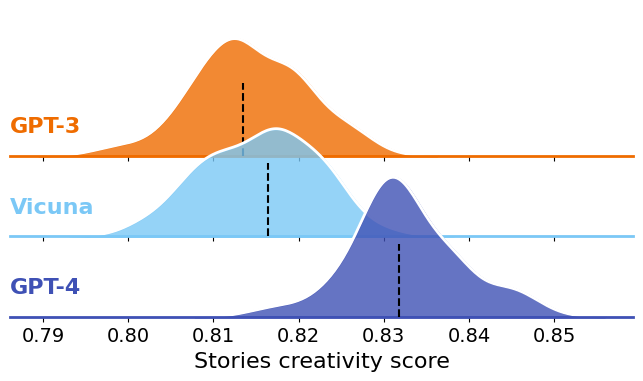

In [14]:
colors = {'GPT-3':'#EF6C00',
          'GPT-4':'#3F51B5',
          'TMDB (human)':'darkgrey',
          'Vicuna':'#7BC8F6'}

df = results_df[['model', 'condition', 'DSI']].loc[(results_df['condition']=='flash-fiction') & (results_df['temp']=='Mid')]
# rename model GPT3 to GPT-3
df["model"].replace("GPT3", "GPT-3", inplace=True)
# rename model GPT4 to GPT-4
df["model"].replace("GPT4", "GPT-4", inplace=True)

df['model'].replace('human', 'TMDB (human)', inplace=True)
# Calculate the medians
medians = df.groupby("model")["DSI"].median()
# Order models by median
order = medians.sort_values().index

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)

g = sns.FacetGrid(df, row="model", hue="model", aspect=9, height=1.3, palette=colors)
# set figure size
g.fig.set_size_inches(7, 4)

# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "DSI",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
    median = medians[label]
    ax.axvline(median, color='black', linestyle='--', ymin=0, ymax=0.5)
    ax.grid(False)

g.map(label, "DSI")

for ax in g.axes.flat:
    ax.set_xlabel('Stories creativity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
#g.fig.suptitle('Divergent Semantic Integration of Synopses', fontsize=20)
#g.savefig(f'../figures/DSI_flash-fiction_mid_temp.png', dpi=300, bbox_inches='tight')


model
GPT-3     0.814318
Vicuna    0.815540
GPT-4     0.832584
Name: DSI, dtype: float64


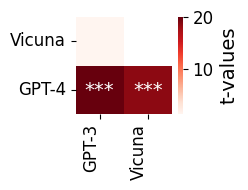

In [15]:
# Calculate the medians
df = results_df[['model', 'condition', 'DSI']].loc[(results_df['condition']=='flash-fiction') & (results_df['temp']=='Mid')]
# rename model GPT3 to GPT-3
df["model"].replace("GPT3", "GPT-3", inplace=True)
# rename model GPT4 to GPT-4
df["model"].replace("GPT4", "GPT-4", inplace=True)

means = df.groupby("model")["DSI"].mean()
# Order models by median
order = means.sort_values().index

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)

#print mean of each model
print(df.groupby("model")["DSI"].mean())
# Recompute the t-values and p-values
tvals_df, pvals_df = compute_tvals_pvals(df, "model")

# Make sure the dataframes are ordered correctly
tvals_df = tvals_df.loc[order, order]
pvals_df = pvals_df.loc[order, order]


#use plot tval function
plot_tvals_matrix(
    tvals_df,
    pvals_df,
    save="../figures/tvals_matrix_FF",
    size=(2.5, 2))

# LZ for Flash-Fictions

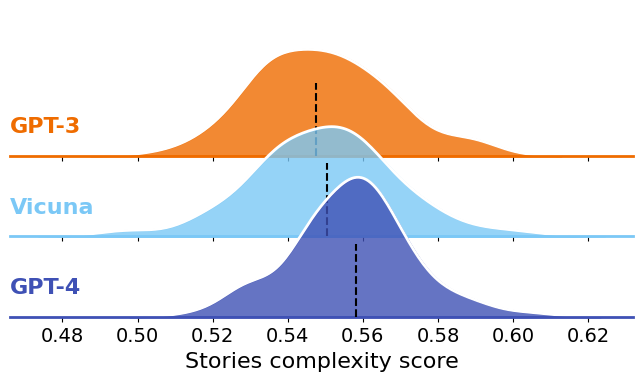

In [16]:

colors = {'GPT-3':'#EF6C00',
          'GPT-4':'#3F51B5',
          'Humans':'darkgrey',
          'Vicuna':'#7BC8F6'}

df = results_df[['model', 'condition', 'lziv']].loc[(results_df['condition']=='flash-fiction') & (results_df['temp']=='Mid')]
# rename model GPT3 to GPT-3
df["model"].replace("GPT3", "GPT-3", inplace=True)
# rename model GPT4 to GPT-4
df["model"].replace("GPT4", "GPT-4", inplace=True)
df["model"].replace("human", "Humans", inplace=True)

# Calculate the medians
medians = df.groupby("model")["lziv"].median()
# Order models by median
order = medians.sort_values().index

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)

g = sns.FacetGrid(df, row="model", hue="model", aspect=9, height=1.3, palette=colors)
# set figure size
g.fig.set_size_inches(7, 4)

# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "lziv",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "lziv", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
    median = medians[label]
    ax.axvline(median, color='black', linestyle='--', ymin=0, ymax=0.5)
    ax.grid(False)

g.map(label, "lziv")

for ax in g.axes.flat:
    ax.set_xlabel('Stories complexity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# set x axis range
#g.set(xlim=(0.60, 0.90))
#g.fig.suptitle('Divergent Semantic Integration of Haikus', fontsize=20)
#g.savefig(f'../figures/lziv_FF_mid_temp.png', dpi=300, bbox_inches='tight')


model
GPT-3     0.549312
Vicuna    0.549647
GPT-4     0.556873
Name: lziv, dtype: float64


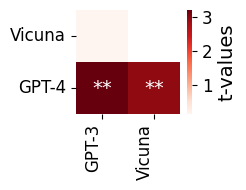

In [17]:
# Calculate the medians
df = results_df[['model', 'condition', 'lziv']].loc[(results_df['condition']=='flash-fiction') & (results_df['temp']=='Mid')]
# rename model GPT3 to GPT-3
df["model"].replace("GPT3", "GPT-3", inplace=True)
# rename model GPT4 to GPT-4
df["model"].replace("GPT4", "GPT-4", inplace=True)

means = df.groupby("model")["lziv"].mean()
# Order models by median
order = means.sort_values().index

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["model"], categories=order, ordered=True)

#print mean of each model
print(df.groupby("model")["lziv"].mean())
# Recompute the t-values and p-values
tvals_df, pvals_df = compute_tvals_pvals(df, "model", metric="lziv")

# Make sure the dataframes are ordered correctly
tvals_df = tvals_df.loc[order, order]
pvals_df = pvals_df.loc[order, order]


#use plot tval function
plot_tvals_matrix(
    tvals_df,
    pvals_df,
    save="../figures/tvals_matrix_FF_lz",
    size=(2.5, 2))

## Plot temperatures for Flash fiction

### GPT-4

Text(0.5, 0.98, 'GPT4 Temperatures for Flash Fiction')

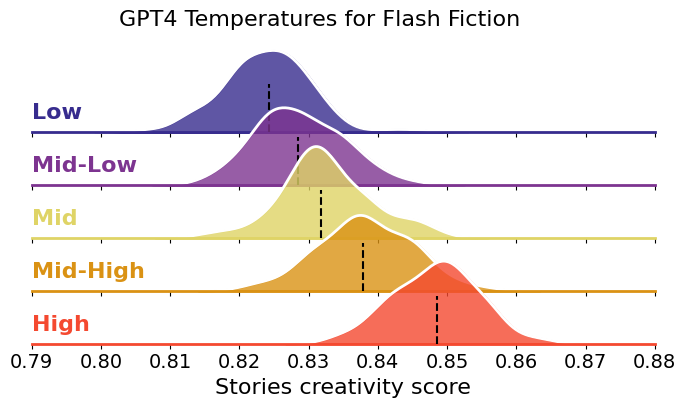

In [18]:
# Make a ridge plot like the one above looking at the effect of temperature on the DSI for each model separetaly
df = results_df.loc[(results_df['condition']=='flash-fiction') & (results_df['model']=='GPT4')]
pal = sns.color_palette('CMRmap',n_colors=5, desat=.9)
pal = [pal[0], pal[1], pal[4], pal[3], pal[2]]
order = ['Low', 'Mid-Low', 'Mid', 'Mid-High', 'High']
g = sns.FacetGrid(df, row="temp", hue="temp", aspect=9, height=2,palette=pal, row_order=order, hue_order=order)
#compute median for each temp
medians = df.groupby("temp")["DSI"].median()
# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "DSI",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
# set figsize
g.fig.set_size_inches(7, 4)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # check if Human is in the label
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
    # plot lines for median
    median = medians[label]
    ax.axvline(median, color='black', linestyle='--', ymin=0, ymax=0.5)
    #remove grid
    ax.grid(False)
g.map(label, "DSI")


for ax in g.axes.flat:
    ax.set_xlabel('Stories creativity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim=(0.79, 0.88))
# add one title for all the subplots
g.fig.suptitle('GPT4 Temperatures for Flash Fiction', fontsize=16)
#g.savefig(f'../figures/GPT4_DSI_ridge_flashfiction_temp.png', dpi=300, bbox_inches='tight')

C:\Users\User\AppData\Local\Temp\ipykernel_1632\3919610965.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model"] = pd.Categorical(df["temp"], categories=order, ordered=True)


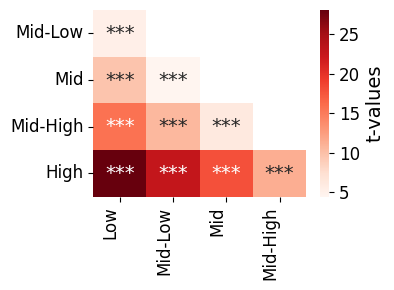

In [19]:
# Calculate the medians
df = results_df.loc[(results_df['condition']=='flash-fiction') & (results_df['model']=='GPT4')]

means = df.groupby("temp")["DSI"].mean()
# Order models by median
order = means.sort_values().index
order = ['Low', 'Mid-Low', 'Mid', 'Mid-High', 'High']

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["temp"], categories=order, ordered=True)

# Recompute the t-values and p-values
tvals_df, pvals_df = compute_tvals_pvals(df, 'model')

# Make sure the dataframes are ordered correctly
tvals_df = tvals_df.loc[order, order]
pvals_df = pvals_df.loc[order, order]


#use plot tval function
plot_tvals_matrix(
    tvals_df,
    pvals_df,
    save='../figures/tvals_matrix_FF_temp',
    size=(4, 3))

## Plot temperatures for Haikus

### GPT4

Text(0.5, 0.98, 'GPT4 Temperatures for Haiku')

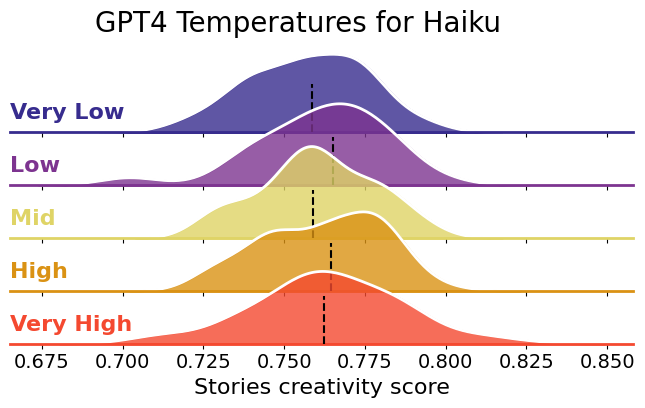

In [20]:
# Make a ridge plot like the one above looking at the effect of temperature on the DSI for each model separetaly
df = results_df.loc[(results_df['condition']=='haiku') & (results_df['model']=='GPT4')]
pal = sns.color_palette('CMRmap',n_colors=5, desat=.9)
pal = [pal[0], pal[1], pal[4], pal[3], pal[2]]
order = ["Very Low", "Low", "Mid", "High", "Very High"]

#compute median for each temp
medians = df.groupby("temp")["DSI"].median()
g = sns.FacetGrid(df, row="temp", hue="temp", aspect=9, height=2,palette=pal, hue_order=order, row_order=order)
# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "DSI",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
# set figsize
g.fig.set_size_inches(7, 4)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # check if Human is in the label
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
    # plot lines for median
    median = medians[label]
    ax.axvline(median, color='black', linestyle='--', ymin=0, ymax=0.5)
    #remove grid
    ax.grid(False)
g.map(label, "DSI")


for ax in g.axes.flat:
    ax.set_xlabel('Stories creativity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# add one title for all the subplots
g.fig.suptitle('GPT4 Temperatures for Haiku', fontsize=20)
#g.savefig(f'../figures/GPT4_DSI_ridge_haiku_temp.png', dpi=300, bbox_inches='tight')

C:\Users\User\AppData\Local\Temp\ipykernel_1632\1972522289.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model"] = pd.Categorical(df["temp"], categories=order, ordered=True)


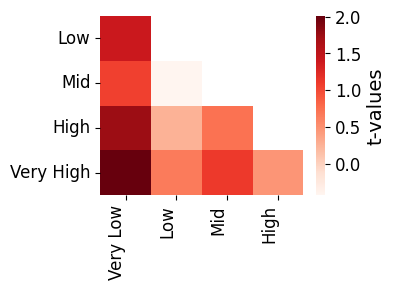

In [21]:
# Calculate the medians
df = results_df.loc[(results_df['condition']=='haiku') & (results_df['model']=='GPT4')]

means = df.groupby("temp")["DSI"].mean()
# Order models by median
order = means.sort_values().index
order = ['Very Low', 'Low','Mid', 'High', 'Very High']

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["temp"], categories=order, ordered=True)

# Recompute the t-values and p-values
tvals_df, pvals_df = compute_tvals_pvals(df, 'model')

# Make sure the dataframes are ordered correctly
tvals_df = tvals_df.loc[order, order]
pvals_df = pvals_df.loc[order, order]


#use plot tval function
plot_tvals_matrix(
    tvals_df,
    pvals_df,
    save='../figures/tvals_matrix_haiku_temp',
    size=(4, 3))

## Plot temperatures for synopsis

### GPT-4

Text(0.5, 0.98, 'GPT-4 Temperatures for Synopsis')

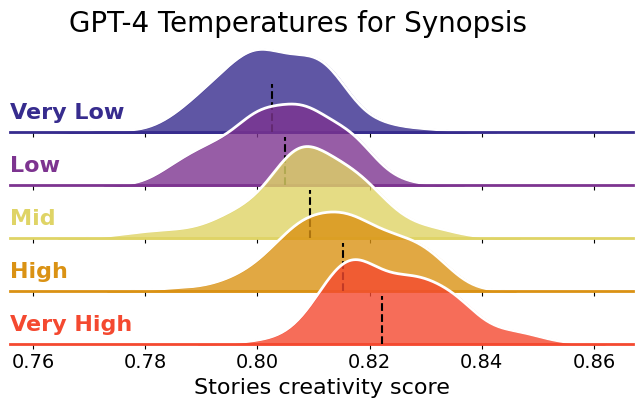

In [22]:
# Make a ridge plot like the one above looking at the effect of temperature on the DSI for each model separetaly
df = results_df.loc[(results_df['condition']=='synopsis') & (results_df['model']=='GPT4')]
pal = sns.color_palette('CMRmap',n_colors=5, desat=.9)
order = ["Very Low", "Low", "Mid", "High", "Very High"]
pal = [pal[0], pal[1], pal[4], pal[3], pal[2]]

# Calculate the medians
medians = df.groupby("temp")["DSI"].median()

g = sns.FacetGrid(df, row="temp", hue="temp", aspect=9, height=2,palette=pal,hue_order=order, row_order=order)
# set figure size
g.fig.set_size_inches(7, 4)
# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "DSI",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # check if Human is in the label
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
    median = medians[label]
    ax.axvline(median, color='black', linestyle='--', ymin=0, ymax=0.5)
    #remove grid
    ax.grid(False)
g.map(label, "DSI")


for ax in g.axes.flat:
    ax.set_xlabel('Stories creativity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# add one title for all the subplots
g.fig.suptitle('GPT-4 Temperatures for Synopsis', fontsize=20)
#g.savefig(f'../figures/GPT4_DSI_ridge_synopsis_temp.png', dpi=300, bbox_inches='tight')

C:\Users\User\AppData\Local\Temp\ipykernel_1632\2046998016.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model"] = pd.Categorical(df["temp"], categories=order, ordered=True)


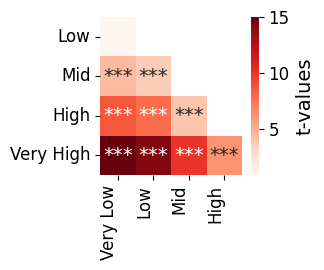

In [23]:
# Calculate the medians
df = results_df.loc[(results_df['condition']=='synopsis') & (results_df['model']=='GPT4')]

medians = df.groupby("temp")["DSI"].median()
# Order models by median
order = medians.sort_values().index

# Create new categorical variable for model respecting this order
df["model"] = pd.Categorical(df["temp"], categories=order, ordered=True)

# Recompute the t-values and p-values
tvals_df, pvals_df = compute_tvals_pvals(df, 'model')

# Make sure the dataframes are ordered correctly
tvals_df = tvals_df.loc[order, order]
pvals_df = pvals_df.loc[order, order]


#use plot tval function
plot_tvals_matrix(
    tvals_df,
    pvals_df,
    save='../figures/tvals_synopsis_temp.png',
    size=(3.4, 2.8))
